In [2]:
# Neuro_Style_Transfer

Practica de Recuperacion 1

SyntaxError: invalid syntax (2761554683.py, line 3)

In [3]:
A continuacion vamos a crear un modelo neuronal que combina una imagen con el estilo de otra, 
creando una imagen completamente nueva a partir de las otras dos. 

Para esto nos hemos basado en modelo Neuro_Style_Trasfer visto en los notebooks 510 y 511, que utiliza el VGG19 de Keras.


SyntaxError: invalid syntax (1066233184.py, line 1)

In [1]:
# Primero importamos las librerias necesarias
import keras
keras.__version__

'2.10.0'

In [2]:

from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [3]:
# Definimos las rutas de las imagenes
url_base  = 'file:///C:/Users/Nico/Desktop/U-tad/3ºINSO/Inteligencia Artificial/inar_b/fotos/cara.png'
url_style = 'file:///C:/Users/Nico/Desktop/U-tad/3ºINSO/Inteligencia Artificial/inar_b/fotos/warhol.png'

base_image_path = keras.utils.get_file('cara.png', origin=url_base)
style_reference_image_path = keras.utils.get_file('warhol.png', origin=url_style)


In [4]:
#Obtenemos las medidas originales (alto y ancho) y establecemos una nueva medida sin que la imagen se vea alterada.
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

#Imprimimos medidas originales y nuevas.

print(str(original_width) + '   ' + str(original_height))

print(str(img_width) + '   ' + str(img_height))

2000   1333
600   400


In [5]:
# Procesamos la imagen para el uso del VGG19
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img


In [6]:
# Utilizamos las funciones de numpy para modificar y redimensionar las imagenes dada y volver a hacer la imagen visim¡ble
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img


In [ ]:
# Este código crea un modelo VGG19 para la clasificación de imágenes y lo configura con caracteristicas

In [7]:
# We will use VGG19 as the underlying NN.

model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"


In [8]:
# Definen algunos pesos que se utilizan para equilibrar las contribuciones
#de pérdida en un algoritmo de transferencia de estilo.


total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-4


In [10]:
# Define una función de pérdida de contenido

def content_loss(x, y):
    return tf.reduce_sum(tf.square(x - y))


In [11]:
# Funcion que define la matriz como medida de estilo
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


In [12]:
# Define la perdida de estilo para medir similitud entre dos imagenes
def style_loss(style_img, combination_img):
    S = style_img
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [13]:
#Pesos para calibrar diferentes terminos de perdida en algoritmo de transferencia de estilo

total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-6


In [14]:
def total_variation_loss(x):
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1 , :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [15]:
# Preprocesamos la imagen y extraemos las caracteristicas

base_image = preprocess_image(base_image_path)
base_image_features = feature_extractor(base_image)[content_layer_name][0, :, :, :]

In [16]:
# Preprocesamiento de la imagen de referencia de estilo y 
# calculan la matriz de gramos de sus características de estilo

style_reference_image = preprocess_image(style_reference_image_path)
style_reference_features = feature_extractor(style_reference_image)
style_reference_features = {
    layer_id : gram_matrix(style_reference_features[layer_id][0,:,:,])
    for layer_id in style_layer_names
}


In [17]:
def compute_loss(combination_image, base_image_features, style_reference_features):

    loss = tf.zeros(shape=())
    features = feature_extractor(combination_image)

    # loss associated to the image shape
    loss = loss + content_weight * content_loss(
        base_image_features, features[content_layer_name][0, :, :, :]
    )

    for layer_name in style_layer_names:
        layer_style_reference_features = style_reference_features[layer_name]
        combination_features = features[layer_name][0, :, :, :]

        style_loss_value = style_loss(layer_style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)

    return loss


In [18]:
#Calculo de perdida gradientes y optimizacion
@tf.function
def compute_loss_and_grads(combination_image, base_image_features, style_reference_features):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image_features, style_reference_features)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 10.0, decay_steps = 10, decay_rate = 0.96
    )
)


In [19]:
combination_image = tf.Variable(preprocess_image(base_image_path))


In [25]:
#Iteracion en un bucle y guardamos archivo ( en este caso cada 100 iteraciones para no llenar mi memoria)
iterations = 500
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image_features, style_reference_features
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}_optimized_code.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=15820.52
Iteration 200: loss=14950.77
Iteration 300: loss=14462.85
Iteration 400: loss=14169.30
Iteration 500: loss=13985.46


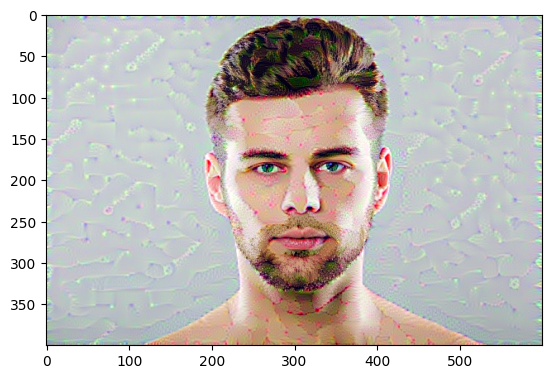

In [26]:
#Imrpimimos la imagen conseguida cuando acaben las 500 iteraciones pedidas
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()


In [ ]:
He escogido estas imagenes ya que queria ver si era capaz de hacer
que aparecierean varias caras o si podia cambiar su rostro entre serio
y feliz pero sin obtener el resultado que queria.

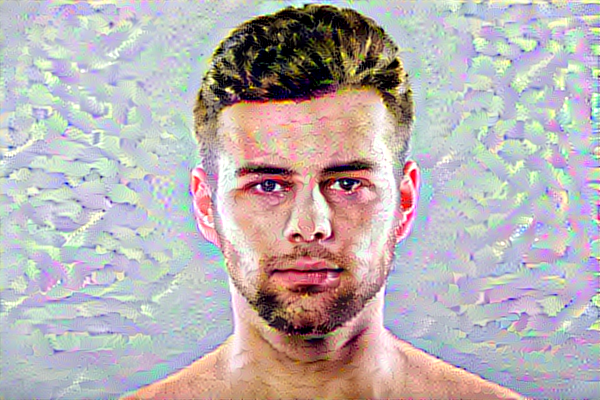

In [27]:
#Aqui dejo una imagen en un entrenamiento anterior que ha sido procesada con 2000 iteraciones y se ven mas cambios
from IPython.display import Image
Image(filename='C:/Users/Nico/Desktop/U-tad/3ºINSO/Inteligencia Artificial/inar_b/Curso Python/combination_image_at_iteration_2000_optimized_code.png')


In [ ]:
#CONCLUSION
Aunque no he obtenido el resultado esperado me parece una practica muy interesante y aprendido mucho sobre el manejo 
de esta tecnologia y el modelo neuronal de transferncia de estilos, es util ya que coge el estilo de una imagen y lo añade a otra.

Tambien he leido que esto se utiliza en publicidad, algunas estrategias de marketing y para la recuperacion de
imagenes antiguas. Esto abre nuevas posibilidades a la inteligencia artificial y procesamiento de imagenes.

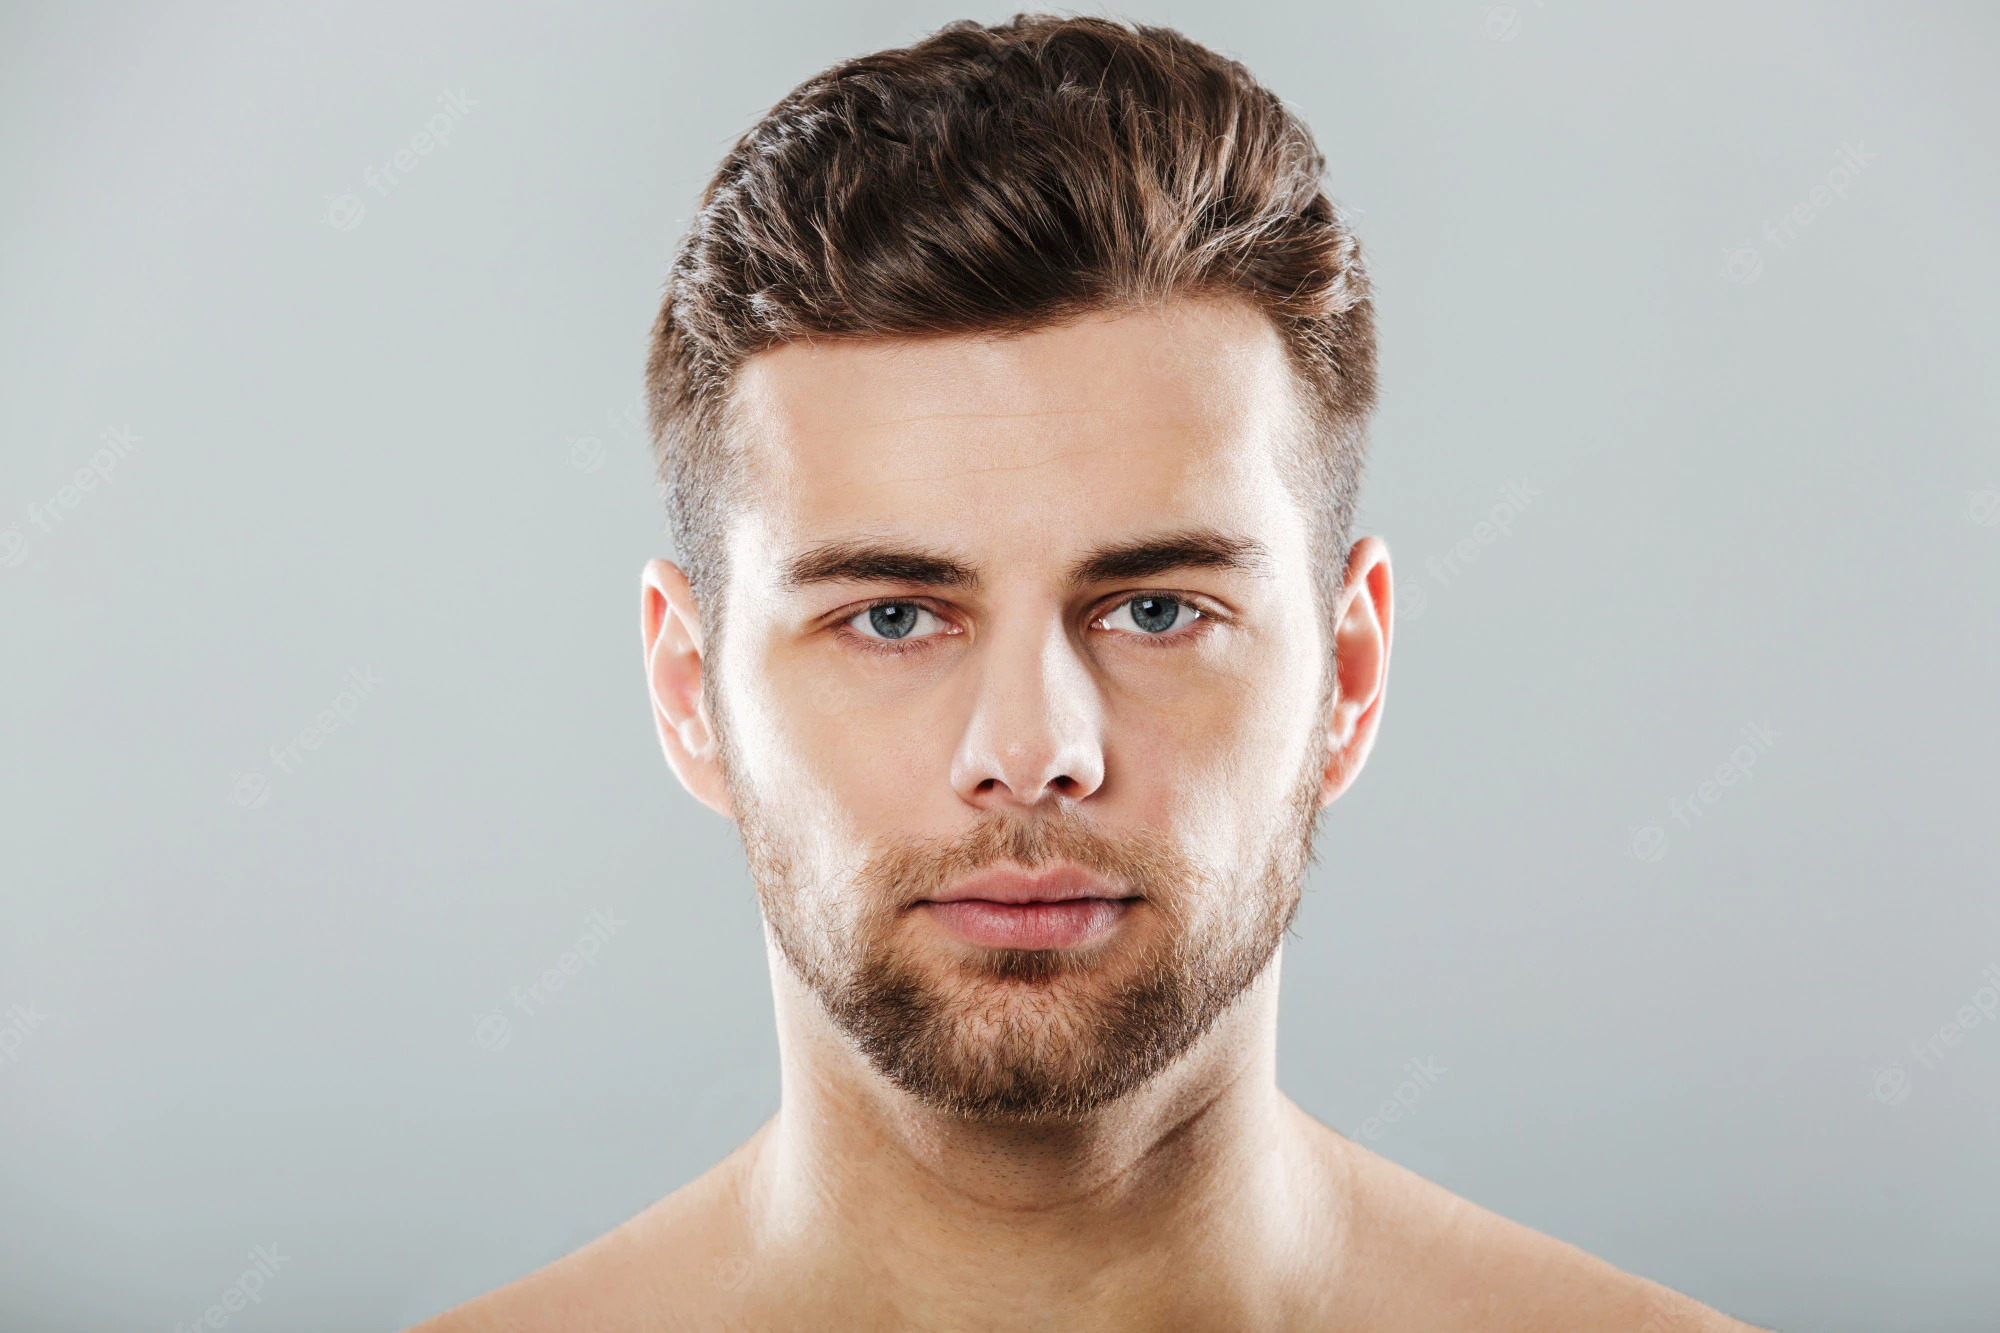

In [32]:
#Imagenes originales
from IPython.display import Image
Image(filename='C:/Users/Nico/Desktop/U-tad/3ºINSO/Inteligencia Artificial/inar_b/fotos/cara.png')



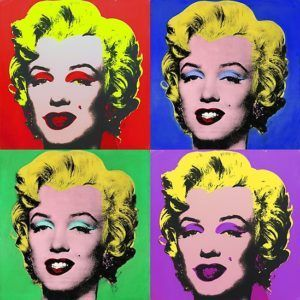

In [33]:
#imagen de estilo
from IPython.display import Image
Image(filename='C:/Users/Nico/Desktop/U-tad/3ºINSO/Inteligencia Artificial/inar_b/fotos/warhol.png')

In [ ]:
Nicolas  Montejano Pisonero 3ºB